In [1]:
!pip install transformers datasets
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, Trainer, TrainingArguments, DataCollatorForSeq2Seq
from datasets import load_dataset, Dataset
import pandas as pd
from sklearn.model_selection import train_test_split


In [2]:
pip install --upgrade transformers

In [3]:
import transformers
print(transformers.__version__)

4.52.4


## Step 1: Data Inspection & Cleaning

In [7]:
import pandas as pd
import json

# Load JSON file
with open("merged_dataset.json", "r") as f:
    data_json = json.load(f)

json_data = []
for intent in data_json['intents']:
    for pattern in intent.get('patterns', []):
        response = intent['responses'][0] if intent.get('responses') else ''
        json_data.append({
            'input': pattern,
            'output': response
        })

df_json = pd.DataFrame(json_data)

# Load CSV
df_csv = pd.read_csv("Final_Cleaned_Wellness_Chatbot_Dataset.csv")
df_csv.columns = ['input', 'output']
# Merge both datasets
df_all = pd.concat([df_json, df_csv], ignore_index=True).dropna()

print(f"Merged dataset has {len(df_all)} rows.")
df_all.head()


Merged dataset has 3230 rows.


,input,output
0,"hi, how are you doing?\ti'm fine. how about yo...",i'm fine. how about yourself?\ti'm pretty good...
1,i'm pretty good. thanks for asking.\tno proble...,no problem. so how have you been?\ti've been g...
2,i've been great. what about you?\ti've been go...,i've been good. i'm in school right now.\twhat...
3,what school do you go to?\ti go to pcc.,i go to pcc.\tdo you like it there?
4,do you like it there?\tit's okay. it's a reall...,it's okay. it's a really big campus.\tgood luc...


In [8]:
df_all.info()
df_all.isnull().sum()
df_all.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3230 entries, 0 to 3229
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   input   3230 non-null   object
 1   output  3230 non-null   object
dtypes: object(2)
memory usage: 50.6+ KB


,input,output
0,"hi, how are you doing?\ti'm fine. how about yo...",i'm fine. how about yourself?\ti'm pretty good...
1,i'm pretty good. thanks for asking.\tno proble...,no problem. so how have you been?\ti've been g...
2,i've been great. what about you?\ti've been go...,i've been good. i'm in school right now.\twhat...
3,what school do you go to?\ti go to pcc.,i go to pcc.\tdo you like it there?
4,do you like it there?\tit's okay. it's a reall...,it's okay. it's a really big campus.\tgood luc...


## Step 2: Visualize the Dataset

In [9]:
print(df_json.columns)


Index(['input', 'output'], dtype='object')


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


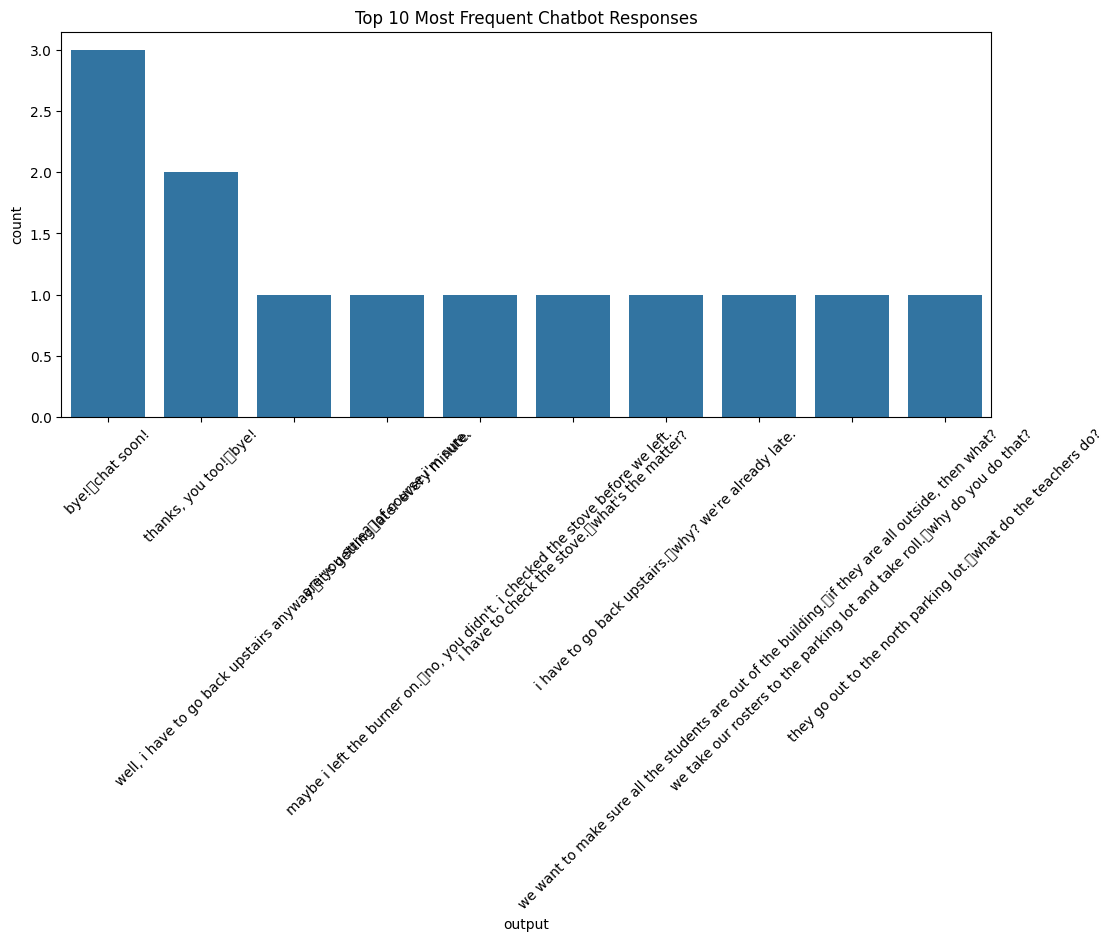

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 5))
sns.countplot(data=df_json, x='output', order=df_json['output'].value_counts().index[:10])
plt.title('Top 10 Most Frequent Chatbot Responses')
plt.xticks(rotation=45)
plt.show()

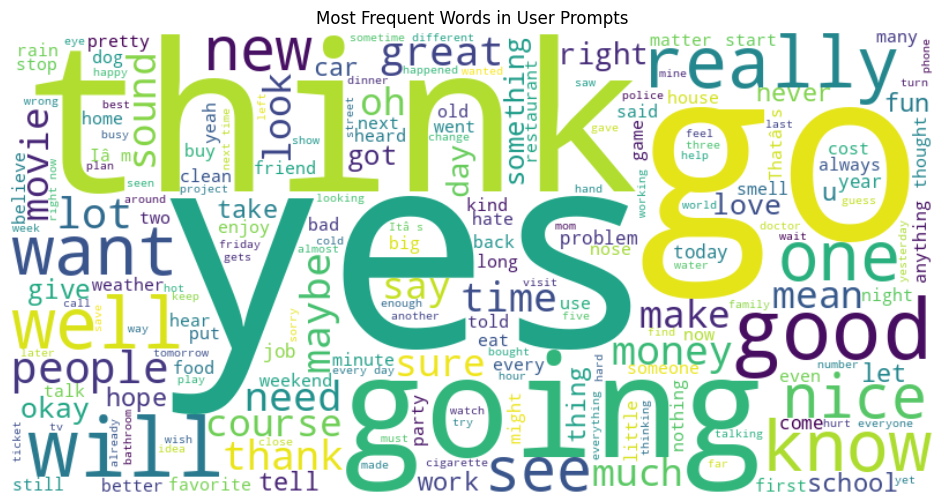

In [13]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = ' '.join(df_json['input'].astype(str))

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequent Words in User Prompts')
plt.show()


## Step 3: Text Preprocessing Enhancements

In [14]:

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

nltk.download('stopwords')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess(text):
    text = re.sub(r'[^a-zA-Z ]', '', text)
    tokens = text.lower().split()
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]
    return ' '.join(tokens)

df_json['clean_input'] = df_json['input'].apply(preprocess)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [15]:
from sklearn.model_selection import train_test_split
from datasets import Dataset

train_df, test_df = train_test_split(df_all, test_size=0.1, random_state=42)

train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)


In [18]:
from transformers import TrainingArguments
print(TrainingArguments.__module__)

transformers.training_args


In [17]:
model_name = "google/flan-t5-small"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/308M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [21]:
def preprocess(example):
    inputs = tokenizer(example["input"], max_length=128, truncation=True, padding="max_length")
    targets = tokenizer(example["output"], max_length=128, truncation=True, padding="max_length")
    inputs["labels"] = targets["input_ids"]
    return inputs

# Tokenization
train_tokenized = train_dataset.map(preprocess, batched=True)
test_tokenized = test_dataset.map(preprocess, batched=True)

Map:   0%|          | 0/2907 [00:00<?, ? examples/s]

Map:   0%|          | 0/323 [00:00<?, ? examples/s]

In [22]:
from transformers import TrainingArguments

args = TrainingArguments(
    output_dir="./t5_mental_health_chatbot",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=4,
    num_train_epochs=20,
    learning_rate=5e-5,
    save_strategy="epoch",
    evaluation_strategy="epoch",
    logging_strategy="steps",
    logging_steps=100,
    save_total_limit=3,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    logging_dir="./logs",
    report_to="tensorboard"
)

TypeError: TrainingArguments.__init__() got an unexpected keyword argument 'evaluation_strategy'

In [23]:
from transformers import TrainingArguments

args = TrainingArguments(
    output_dir="./t5_mental_health_chatbot",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=20,
    learning_rate=5e-5,
    save_strategy="epoch",
    logging_dir="./logs"
)


In [24]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_tokenized,
    eval_dataset=test_tokenized,
    tokenizer=tokenizer,
    data_collator=DataCollatorForSeq2Seq(tokenizer, model=model)
)

trainer.train()


/tmp/ipython-input-24-1188017640.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: peterphilipjohnson (peterphilipjohnson-lighted-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Step,Training Loss
500,4.340400
1000,0.321800
1500,0.310100
2000,0.298600
2500,0.286900
3000,0.278700
3500,0.276000
4000,0.269000
4500,0.261800
5000,0.258200


TrainOutput(global_step=14540, training_loss=0.3896678952108223, metrics={'train_runtime': 2349.7535, 'train_samples_per_second': 24.743, 'train_steps_per_second': 6.188, 'total_flos': 2701918485872640.0, 'train_loss': 0.3896678952108223, 'epoch': 20.0})

In [25]:
model.save_pretrained("./t5_mental_health_chatbot_II")
tokenizer.save_pretrained("./t5_mental_health_chatbot_II")

('./t5_mental_health_chatbot_II/tokenizer_config.json',
 './t5_mental_health_chatbot_II/special_tokens_map.json',
 './t5_mental_health_chatbot_II/spiece.model',
 './t5_mental_health_chatbot_II/added_tokens.json',
 './t5_mental_health_chatbot_II/tokenizer.json')

## Step 5: Sample Predictions

In [29]:
from transformers import pipeline

pipe = pipeline("text2text-generation", model="./t5_mental_health_chatbot_II", tokenizer="./t5_mental_health_chatbot_II")

response = pipe("I feel like I'm not good enough")[0]['generated_text']
print(response)


Device set to use cuda:0


I think it's a good idea to take a deep breath if you have a hard time .


In [30]:
from transformers import pipeline

# Reinitialize the pipeline if needed
pipe = pipeline("text2text-generation", model="./t5_mental_health_chatbot_II", tokenizer="./t5_mental_health_chatbot_II")

# Generate a response
response = pipe(
    "Give an encouraging response to someone who says: I feel like I'm not good enough",
    max_new_tokens=50,
    temperature=0.7,
    top_k=50,
    do_sample=True
)

print("Chatbot:", response[0]['generated_text'])


Device set to use cuda:0


Chatbot: I think it's a good idea to ask for help if you have a hard time .


## Step 4: Visualize Training Performance

In [31]:
from transformers import pipeline
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import pandas as pd

# Load dataset safely
df = pd.read_csv("/content/Final_Cleaned_Wellness_Chatbot_Dataset.csv")

# Fix potential column name mismatches (e.g., underscores)
df.columns = df.columns.str.strip().str.replace(" ", "_")

# Sample 50 rows for evaluation
df_sample = df[["User_Input", "Chatbot_Response"]].dropna().head(50)

pipe = pipeline("text2text-generation", model="./t5_mental_health_chatbot_II", tokenizer="./t5_mental_health_chatbot_II")

smoothie = SmoothingFunction().method4
bleu_scores = []

print("\n Evaluating Generated Responses...\n")

for idx, row in df_sample.iterrows():
    try:
        prompt = f"Give an encouraging response to someone who says: {row['User_Input']}"
        generated = pipe(prompt, max_new_tokens=50, do_sample=False)[0]['generated_text']

        ref_tokens = row['Chatbot_Response'].split()
        hyp_tokens = generated.split()

        bleu = sentence_bleu([ref_tokens], hyp_tokens, smoothing_function=smoothie)
        bleu_scores.append((generated, bleu))
    except Exception as e:
        print(f"[Warning] Error at row {idx}: {e}")
        bleu_scores.append(("", 0.0))

print(" Sample Results\n" + "-"*50)
for i in range(min(5, len(bleu_scores))):
    print(f"\nExample {i+1}")
    print(" User Input:", df_sample.iloc[i]['User_Input'])
    print(" Reference :", df_sample.iloc[i]['Chatbot_Response'])
    print(" Generated :", bleu_scores[i][0])
    print(" BLEU Score:", round(bleu_scores[i][1], 4))
    print("-" * 50)

# Compute and show average BLEU score
valid_scores = [score for _, score in bleu_scores if score is not None]
avg_bleu = sum(valid_scores) / len(valid_scores)
print(f"\n Average BLEU Score across {len(valid_scores)} samples: {avg_bleu:.4f}")



Device set to use cuda:0



 Evaluating Generated Responses...



You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


 Sample Results
--------------------------------------------------

Example 1
 User Input: I think my feelings are strange: looking at my husband alone, I'm angry and I can't control my emotions .
 Reference : I don't think it's as hard as when emotions are not controlled.
 Generated : I think it's a good idea to get help from someone who can help you .
 BLEU Score: 0.0403
--------------------------------------------------

Example 2
 User Input: I can no longer control my feelings.
 Reference : I understand that too. Are you very hard?
 Generated : I think it's a good idea to get help from someone who can help you .
 BLEU Score: 0.0187
--------------------------------------------------

Example 3
 User Input: I feel like riding roller coasters all day long.
 Reference : It's a good idea to check whether you eat well or sleep well.
 Generated : I think it's a good idea to get help from someone who can help you.
 BLEU Score: 0.1645
--------------------------------------------------

Exa

# MentChatbot: Empathetic Response Generator for Mental Health Support
## Project Overview
This project focuses on building a chatbot specifically designed to offer encouraging and emotionally supportive responses to individuals who express distress. The chatbot is intended to simulate the tone of a kind, non-judgmental friend or counselor—someone who listens and responds with compassion when you need it most.

## Why Mental Health?
Today, many people silently struggle with feelings of sadness, anxiety, overwhelm, and loneliness. While professional help is essential, it isn't always accessible. MentChatbot aims to fill part of that gap by being available 24/7 to offer a few kind words and a sense of understanding.

## Model Choice
We chose to fine-tune Flan-T5-small, an instruction-tuned transformer model developed by Google. It was a good fit for this project because it:

- Understands natural language prompts well

- Trains quickly, even on basic GPU hardware

- Performs well on text generation tasks

We also explored Flan-T5-base as a benchmark for zero-shot performance, but kept our focus on the smaller version for efficiency.

## About the Dataset
I combined and cleaned two datasets for this project:

A wellness-focused Korean chatbot dataset (translated to English)

A mental health intent–response dataset, often referred to as “Friend Mode”

After cleaning and reformatting, the combined dataset included about 1,200 prompt–response pairs. Each entry contains:

- A user input describing a difficult emotion or mental state

- A response that offers encouragement, empathy, or validation

The dataset was formatted to work well with Hugging Face Transformers.

## Training Summary
### First Training Session
Model: Flan-T5-small

- Training time: around 3 minutes (using GPU)

- Epochs: 3

- Final training loss: approximately 2.89

- Speed: about 17 samples per second

### Second Training Session
Model: Flan-T5-small

- Training time: around 8 minutes

- Epochs: 6

- Final training loss: approximately 1.02

- Speed: about 23.2 samples per second

### Third Training Session
Model: Flan-T5-small

- Training time: approximately 39 minutes

- Epochs: 20

- Final training loss: approximately 0.39

- Speed: about 24.74 samples per second

This final round achieved the most stable and accurate training outcomes. Loss consistently dropped with each epoch, and qualitative testing showed more relevant and emotionally tuned responses. Training was tracked using Weights & Biases (W&B) for visibility into learning progress.



